## Praca domowa 2
### Temat Kuzushiji-MNIST
#### Grzegorz Grygorowicz

崩し字(kuzushiji) - z japońskiego zawalone znaki, są to znaki zapisywane kursywą przed reformą w okresem Meiji, po której umiejętność czytania tych znaków zaczeła przepadać z czasem. Obecnie umieją je czytać tylko eksperci.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy as sp
import random

In [2]:
BATCH_SIZE = 64
SEED = 278839

#### Dane

Pierwszą bazą danych jest 70000 obrazków o wymiarze 28x28, w odcieni szarości. Jest 10 klas znaków hiragany: お、き、す、つ、な、は、ま、や、れ、を.

Drugą bazą danych jest augumentacja tych obrazów, najpiew obrócenie je randomowo i przejście przez funckje magnitudy gradientu, przez co nie są zamalowane całe znaki a jedynie kontur.

In [3]:
train_set = np.load("kmnist-train-imgs.npz")["arr_0"]
train_labels = np.load("kmnist-train-labels.npz")["arr_0"]

test_set = np.load("kmnist-test-imgs.npz")["arr_0"]
test_labels = np.load("kmnist-test-labels.npz")["arr_0"]

length = len(np.unique(train_labels))

train_labels = to_categorical(train_labels, length)
test_labels = to_categorical(test_labels, length)

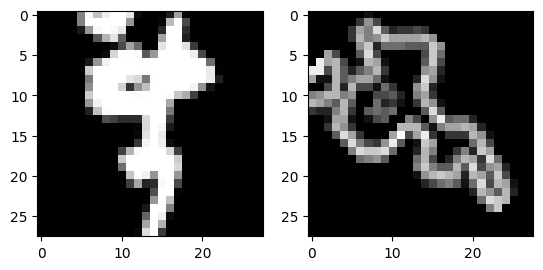

In [5]:
img1 = train_set[15]
img2 = sp.ndimage.rotate(img1, angle=45, reshape=False)
z = sp.ndimage.gaussian_gradient_magnitude(img2, 0.3)
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(z, cmap="gray")

In [11]:
augmentedTrainData = []
augmentedTestData = []
random.seed(SEED)
for image in test_set:
    rotatedImage = sp.ndimage.rotate(image, angle=random.randint(0, 360), reshape=False)
    augmentedImage = sp.ndimage.gaussian_gradient_magnitude(rotatedImage, 0.3)
    augmentedTestData.append(augmentedImage)

for image in train_set:
    rotatedImage = sp.ndimage.rotate(image, angle=random.randint(0, 360), reshape=False)
    augmentedImage = sp.ndimage.gaussian_gradient_magnitude(rotatedImage, 0.3)
    augmentedTrainData.append(augmentedImage)

aTestData = np.array(augmentedTestData)
# a1Test = {"arr_0": aTestData}
# np.savez('a3/a3Test.npz', **a1Test)

aTrainData = np.array(augmentedTrainData)
# a1Train = {"arr_0": aTrainData}
# np.savez('a3/a3Train.npz', **a1Train)

#### Konwolucyjna sięc  neuronowa
2 warstwy konwolucji. W pierwszej 32 węzły, w drugiej 64 z filterami 5x5, z funckją aktywacji relu. Wielkość inputu 28x28x1 i paddingiem takim samym.
Normalizacja
40% dropout

In [9]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1), padding="same"))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(length, activation="softmax", kernel_regularizer='l2'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

Trenowanie na danych oryginalnych

In [7]:
history = model.fit(train_set, train_labels, epochs=4, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/4
938/938 [==============================] - 40s 41ms/step - loss: 0.5211 - accuracy: 0.8554
Epoch 2/4
938/938 [==============================] - 40s 43ms/step - loss: 0.2028 - accuracy: 0.9443
Epoch 3/4
938/938 [==============================] - 41s 44ms/step - loss: 0.1449 - accuracy: 0.9601
Epoch 4/4
938/938 [==============================] - 41s 44ms/step - loss: 0.1120 - accuracy: 0.9686


Trenowanie na danych zaugumentowanych

In [12]:
history2 = model.fit(aTrainData, train_labels, epochs=4, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/4
938/938 [==============================] - 37s 38ms/step - loss: 1.9003 - accuracy: 0.3098
Epoch 2/4
938/938 [==============================] - 43s 46ms/step - loss: 1.4504 - accuracy: 0.4762
Epoch 3/4
938/938 [==============================] - 39s 42ms/step - loss: 1.2639 - accuracy: 0.5357
Epoch 4/4
938/938 [==============================] - 39s 42ms/step - loss: 1.1767 - accuracy: 0.5628


Wyświetlenie dla oby dwóch wersji baz danych wykresów starty i dokładności.

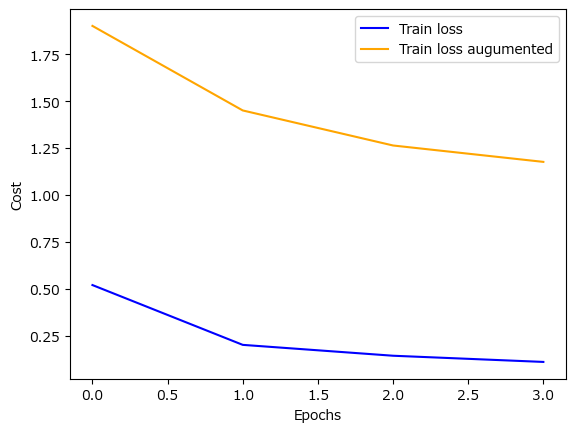

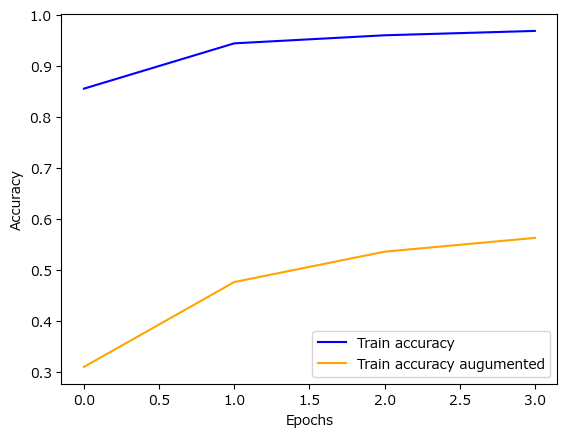

In [13]:
plt.plot(history.history['loss'], label='Train loss', color='blue')
plt.plot(history2.history['loss'], label='Train loss augumented', color='orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

plt.plot(history.history['accuracy'], label='Train accuracy', color='blue')
plt.plot(history2.history['accuracy'], label='Train accuracy augumented', color='orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Wyświetelnie dla oryginalnych danych testowych straty i dokładności oraz macierzy błędu.

Evaluate model on test data
157/157 [==============================] - 2s 10ms/step - loss: 0.2878 - accuracy: 0.9421
test loss, test accuracy: [0.28784579038619995, 0.9420999884605408]
Prediction
313/313 [==============================] - 2s 5ms/step


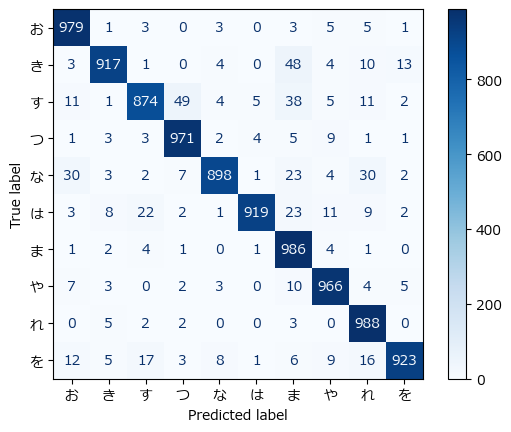

In [8]:
print("Evaluate model on test data")
results = model.evaluate(test_set, test_labels, batch_size=BATCH_SIZE)
print("test loss, test accuracy:", results)

print("Prediction")
prediction = model.predict(test_set)
conMatrix = confusion_matrix(test_labels.argmax(axis=1), prediction.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()

Wyświetelnie dla zaugumentowanych danych testowych straty i dokładności oraz macierzy błędu.

Evaluate model on test data
157/157 [==============================] - 2s 9ms/step - loss: 1.2164 - accuracy: 0.6277
test loss, test accuracy: [1.216416597366333, 0.6276999711990356]
Prediction
313/313 [==============================] - 2s 6ms/step


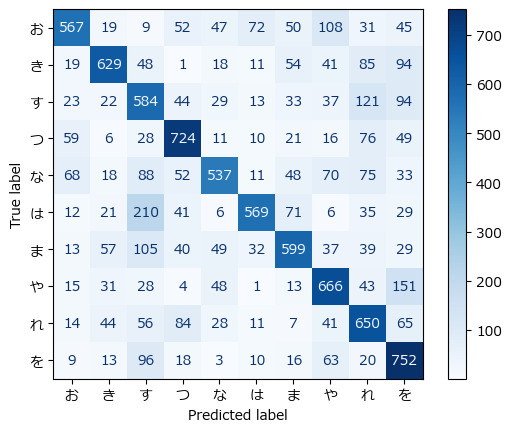

In [14]:
print("Evaluate model on test data")
results = model.evaluate(aTestData, test_labels, batch_size=BATCH_SIZE)
print("test loss, test accuracy:", results)

print("Prediction")
prediction = model.predict(aTestData)
conMatrix = confusion_matrix(test_labels.argmax(axis=1), prediction.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### K-Najbliższych Sąsiadów

k = 3

Przygotowanie danych by działały dla KNeighborsClassifier i MLPClassifier

In [19]:
nsamples, nx, ny = train_set.shape
train_set_k = train_set.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_set.shape
test_set_k = test_set.reshape((nsamples,nx*ny))

nsamples, nx, ny = aTrainData.shape
aTrain_set_k = aTrainData.reshape((nsamples,nx*ny))

nsamples, nx, ny = aTestData.shape
aTest_set_k = aTestData.reshape((nsamples,nx*ny))

Dla oryginalnych danych

Wyświetlenie dokładności i macierzy błędu.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(train_set_k, train_labels)

print(knn.score(test_set_k, test_labels)*100)

y_true = test_labels
y_pred = knn.predict(test_set_k)

conMatrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

90.73


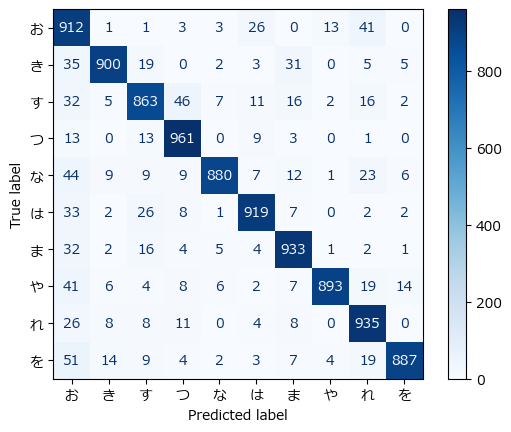

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dla danych zaugumentowanych

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(aTrain_set_k, train_labels)

print(knn.score(aTest_set_k, test_labels)*100)

y_true = test_labels
y_pred = knn.predict(aTest_set_k)

conMatrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

61.29


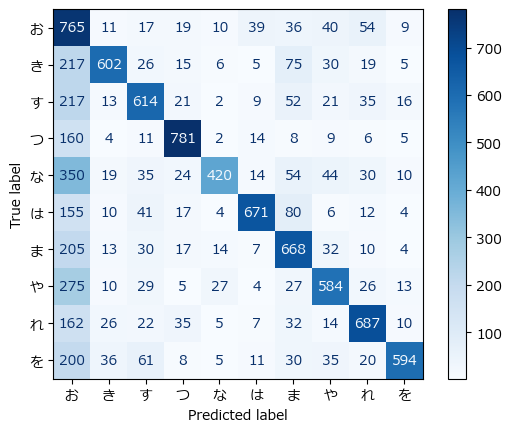

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Sieć neuronowa

Dla oryginalnych danych

In [28]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='adam', hidden_layer_sizes=(50, 50, 50), random_state=SEED, activation="relu", max_iter=500)
nn.fit(train_set_k, train_labels)

print(nn.score(test_set_k, test_labels) * 100)

y_true = test_labels
y_pred = nn.predict(test_set_k)

conMatrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

82.72


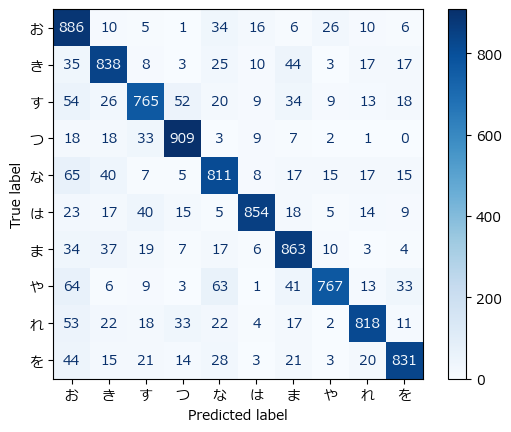

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dla zaugumentowanych danych

In [30]:
nn = MLPClassifier(solver='adam', hidden_layer_sizes=(50, 50, 50), random_state=SEED, activation="relu", max_iter=500)
nn.fit(aTrain_set_k, train_labels)

print(nn.score(aTest_set_k, test_labels) * 100)

y_true = test_labels
y_pred = nn.predict(aTest_set_k)

conMatrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

38.98


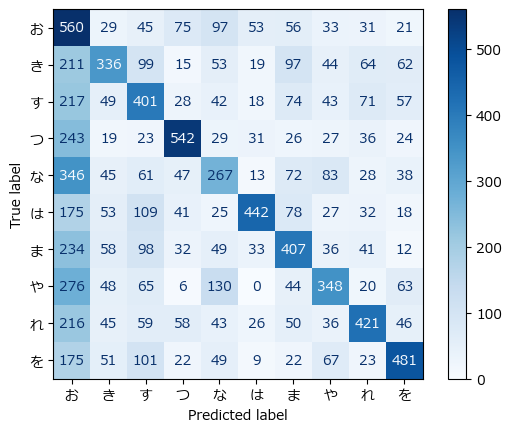

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=conMatrix, display_labels="おきすつなはまやれを")
plt.rcParams['font.family'] = 'Meiryo'
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Podsumowanie

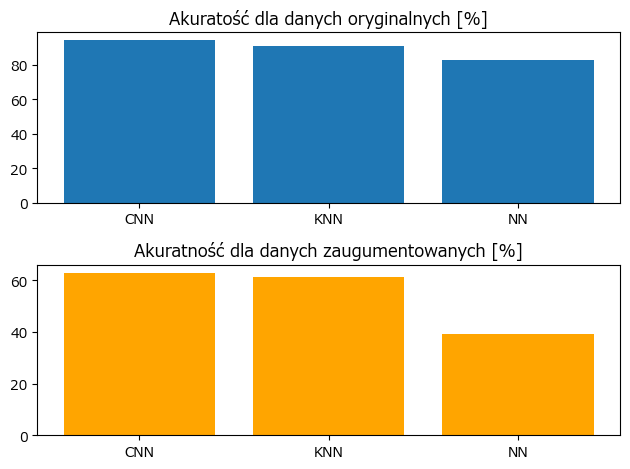

In [33]:
types = ["CNN", "KNN", "NN"]
acc = [94.20999884605408, 90.73, 82.72]
acc_a = [62.76999711990356, 61.29, 38.98]

fig, ax = plt.subplots(2)
ax[0].bar(types, acc)
ax[0].set_title("Akuratość dla danych oryginalnych [%]")
ax[1].bar(types, acc_a, color='orange')
ax[1].set_title("Akuratność dla danych zaugumentowanych [%]")
plt.tight_layout()
plt.show()

Jak można zauważyć na wykresie, najdokładniejszym klasyfikatorem jest konwolucyjna sieć neuronowa ok 94% dla oryginalnych danych i ok 63% dla zaugumentowanych danych. Potem jest klasyfikator K-najbliższych sąsiadów ok 91% dla oryginalnych danych i ok 61% dla zaugumentowanych danych. Najgorzej wypadła sieć neuronowa z wynikiem ok 83% dla oryginalnych danych i ok 39% dla zaugumentowanych danych.

#### Bibliografia

- https://www.kaggle.com/datasets/anokas/kuzushiji

- https://www.upgrad.com/blog/basic-cnn-architecture/

- Wykłady i laboratoria